In [3]:
import pandas as pd
import panel as pn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.figure import Figure
import param
import hvplot.pandas
import altair as alt
import requests
#import streamlit as st
import pywaffle
from pywaffle import Waffle
import plotly.express as px

In [4]:
# Load data
data = pd.read_csv('/Users/sarahweinflash/Desktop/Education/CIS 9655 - Data Visualization/merged_final.csv')
country_code = pd.read_csv('/Users/sarahweinflash/Desktop/Education/CIS 9655 - Data Visualization/wikipedia-iso-country-codes.csv')
gdp = pd.read_csv('/Users/sarahweinflash/Desktop/Education/CIS 9655 - Data Visualization/WITS-Country-Timeseries.csv')

# Merge data with country code
data = data.merge(country_code, left_on='LOCATION', right_on='Alpha-3 code')
data = data[['YEAR', 'REGISTERED_VEHICLES','CAR_ACCIDENTS','English short name lower case']]
data = data.rename(columns={'YEAR':'Year', 'REGISTERED_VEHICLES':'Vehicles','CAR_ACCIDENTS':'Injuries','English short name lower case':'Country'})

# Melt GDP data
gdp = gdp.melt(id_vars = 'Country Name', value_vars = ['2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021'], var_name='Year', value_name='GDP')
gdp['Year'] = gdp['Year'].apply(int)

# Merge data & GDP data
data = data.merge(gdp, left_on=['Country','Year'], right_on=['Country Name', 'Year'])
data = data[['Country','Year','Injuries','GDP','Vehicles']]
data['Transformed_GDP'] = data['GDP'].apply(np.sqrt)
data = pd.DataFrame(data.groupby(['Country','Year'])[['Transformed_GDP','Injuries','Vehicles','GDP']].agg('mean'))
data = data.reset_index()

# Separate countries by GDP
grouped_data = data.groupby('Country').agg('sum')
grouped_data.sort_values(by='Transformed_GDP',ascending=False)
Rank = []
for i in data['Country']:
    if i in ['United States','Japan','United Kingdom', 'Germany', 'Italy','Norway','Belgium','Poland','Sweden','Netherlands','Switzerland','Australia','Turkey','Spain','Canada','Austria']:
        Rank.append('Higher GDP')
    else:
        Rank.append('Lower GDP')
data['Rank'] = Rank
rank0 = data[data['Rank'] == 'Higher GDP']
rank1 = data[data['Rank'] == 'Lower GDP']

In [5]:
# Scatterplot - Slider 

slider = alt.binding_range(min=2011, max=2021, step=1, name='Year')
selection = alt.selection_point(fields=['Year'], bind=slider)
opacity = alt.condition(selection, alt.value(1.0), alt.value(0))

order1 = data.groupby('Country').agg('sum')
order1 = order1.sort_values('Injuries', ascending=False)
order1 = list(order1.index)

chart1 = alt.Chart(data, title = 'Injuries in Road Accidents by Country').mark_point(filled=True, size=50, color='salmon').encode(
    x = alt.X('Country:N', sort = order1),
    y = 'Injuries:Q',
    opacity = opacity
).add_params(selection)

line1 = alt.Chart().mark_rule(color='#6b6ecf').encode(
    y='mean(Injuries):Q',
    size=alt.SizeValue(3)
).transform_filter(
    selection
)

alt.layer(chart1, line1, data=data) 

/var/folders/m_/bn7_5xgd5k78dxpv8nsvb1r00000gn/T/ipykernel_47427/2710675299.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  order1 = data.groupby('Country').agg('sum')


alt.LayerChart(...)

In [6]:
# Scatterplot - Injuries per Year
    # separated by Top 5 vs Total
    # incl regression lines

data_grouped1 = data.groupby(['Country','Year'], as_index=False).agg('sum')
data_grouped1.sort_values(by='Injuries')
data_grouped1 = data_grouped1[data_grouped1['Country'].isin(['United States','New Zealand','Belgium','Austria','Japan'])]

points1 = alt.Chart(data_grouped1, title = 'Vehicular Injuries per Year').mark_point(filled=True, opacity=1).encode(
    x = 'Year:O',
    y = 'Injuries:Q',
    color = alt.Color('Country:N'),
    tooltip = ['Country:N']
)

line1 = points1.transform_regression('Year','Injuries').mark_line(opacity=1, color='#6b6ecf').encode(color=alt.Color(legend=None))

points2 = alt.Chart(data, title = 'Vehicular Injuries per Year').mark_point(filled=True, opacity=0.3, color='black').encode(
    x = 'Year:O',
    y = 'Injuries:Q'
)

line2 = points2.transform_regression('Year','Injuries').mark_line(opacity=1, color='black').encode(color=alt.Color(legend=None)) 

annotation1 = alt.Chart(data).mark_text(
    align = 'left',
    fontSize = 15,
    color = '#6b6ecf'
).encode(
    x = alt.value(225),
    y = alt.value(150),
    text = alt.value(['Top 5'])
)

annotation2 = alt.Chart(data).mark_text(
    align = 'left',
    fontSize = 15,
    color = 'black'
).encode(
    x = alt.value(225),
    y = alt.value(225),
    text = alt.value(['All Countries'])
)    
points2 + points1 +  line1 + line2 + annotation1 + annotation2

/var/folders/m_/bn7_5xgd5k78dxpv8nsvb1r00000gn/T/ipykernel_47427/4006470148.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_grouped1 = data.groupby(['Country','Year'], as_index=False).agg('sum')


alt.LayerChart(...)

/var/folders/m_/bn7_5xgd5k78dxpv8nsvb1r00000gn/T/ipykernel_47221/2264218409.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_grouped = data.groupby('Country').agg('sum')


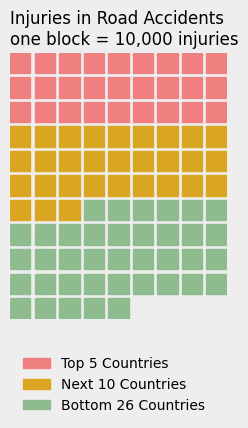

In [5]:
# Group & Filter Data 
    
    # sum the injuries by country
data_grouped = data.groupby('Country').agg('sum')
data_grouped = data_grouped.reset_index()
data_grouped = data_grouped[['Country','Injuries']]
#data_grouped.sort_values('Injuries', ascending=False)

    # divide into categories
filtered_data = {}
filtered_data['Top 5 Countries'] = data_grouped[data_grouped['Injuries']>50000].sum()[1]
filtered_data['Next 10 Countries'] = data_grouped[(data_grouped['Injuries']>35000) & (data_grouped['Injuries']<50000)].sum()[1]
filtered_data['Bottom 26 Countries'] = data_grouped[data_grouped['Injuries']<35000].sum()[1]

    # divide to generate appropriate number of blocks
for i,j in filtered_data.items():
    filtered_data[i] = int(j/10000)

fig = plt.figure(
    FigureClass=Waffle,
    rows=11,
    values=filtered_data,
    colors=['lightcoral','goldenrod','darkseagreen'],
    title={'label': 'Injuries in Road Accidents \none block = 10,000 injuries', 'loc': 'left'},
    labels=[f"{k}" for k, v in filtered_data.items()],
    legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.4), 'ncol': 1, 'framealpha': 0},
    starting_location='NW',
    vertical=True
)
fig.set_facecolor('#EEEEEE')
plt.show()

In [1]:
# Create plots for GDP/Vehicle/Injury Comparison

brush = alt.selection_interval()

# Scatterplots
points1 = alt.Chart(rank0, title = 'Vehicular Injuries by Number of Vehicles per Country').mark_point(filled=True, color='salmon',opacity=0.5).encode(
    alt.X('Vehicles:Q', scale=alt.Scale(domain=[0, 3500])),
    alt.Y('Injuries:Q', scale=alt.Scale(domain=[0, 10000])),
    tooltip = ['Country']
)
points2 = alt.Chart(rank1, title = 'Vehicular Injuries by Number of Vehicles per Country').mark_point(filled=True, color='#6b6ecf',opacity=0.5).encode(
    alt.X('Vehicles:Q', scale=alt.Scale(domain=[0, 3500])),
    alt.Y('Injuries:Q', scale=alt.Scale(domain=[0, 10000])),
    tooltip = ['Country'],
    color=alt.Color('Rank:N', scale = alt.Scale(domain=['Higher GDP', 'Lower GDP'], range=['salmon', '#6b6ecf']))
).add_params(brush)

# Boxplots
bp0 = alt.Chart(rank0).mark_boxplot(color='salmon').encode(y = alt.Y('Injuries:Q', title=None, scale=alt.Scale(domain=[0,10000])))
bp1 = alt.Chart(rank1).mark_boxplot(color='#6b6ecf').encode(y = alt.Y('Injuries:Q', title=None, scale=alt.Scale(domain=[0,10000])))
bp00 = alt.Chart(rank0).mark_boxplot(color='salmon').encode(x = alt.X('Vehicles:Q', title=None, scale = alt.Scale(domain=[0,3500])))
bp11 = alt.Chart(rank1).mark_boxplot(color='#6b6ecf').encode(x = alt.X('Vehicles:Q', title=None, scale = alt.Scale(domain=[0,3500])))

# Regression Lines
line1 = points1.transform_regression('Vehicles','Injuries').mark_line(opacity=1, color='salmon') 
line2 = points2.transform_regression('Vehicles','Injuries').mark_line(opacity=1, color='#6b6ecf') 

# Bar Chart
bars = alt.Chart(data).mark_bar().encode(
    x = alt.X('count()', scale=alt.Scale(domain=[0,11])),
    y = alt.Y('Country:N'),
    color=alt.Color('Rank:N', scale=alt.Scale(domain=['Lower GDP', 'Higher GDP'], range=['#6b6ecf','salmon']))
).transform_filter(
    brush
)

# Print Chart
alt.layer(line2, points2, data=rank1) + alt.layer(points1, line1, data=rank0) & bp11 & bp00 | bp1 | bp0 | bars

NameError: name 'alt' is not defined